# Face classification ussing Pytorch

By: Ricardo Lazo Vasquez

In this project I will classify the Race, Age, and Gender of different people. I will use images of faces with dimentions of 224 x 224 RGB. The Dataset is in this [URL](https://www.kaggle.com/datasets/ghaidaalatoum/fairface). 

## Objectives

Concretely, I want to see if I can classify highly biased races by AIs with a dedicated model designed to classify photos of people of different races, ages and genders.

## Reasons of the approach

I selected the deep learning approach because of the challenge and the naturality of the problem. The desired architecture must be able to classify the photos in multiple independant categories, so a deep learning approach is more reliable to this approach.

## Common imports

First, I will import the used dependencies for this project.

In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image

from tqdm import tqdm

from sklearn.metrics import confusion_matrix

sns.set()

## CUDA Testing and Used Graphic card

For this project I used the following GPU:

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using {torch.cuda.get_device_name(0)}.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using NVIDIA GeForce RTX 4070 Ti SUPER.


## Dataset importing and exploration

In this stage, I want to see the dataset distribution, common values, and possible errors. 

In [3]:
metadata_train = pd.read_csv("../data/fairface/fairface_label_train.csv")
metadata_val = pd.read_csv("../data/fairface/fairface_label_val.csv") 

display(metadata_train.head(3))
display(metadata_val.head(3))

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False


,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True


In [4]:
metadata_train.describe()

,file,age,gender,race,service_test
count,86744,86744,86744,86744,86744
unique,86744,9,2,7,2
top,train/1.jpg,20-29,Male,White,False
freq,1,25598,45986,16527,46492


In [5]:
metadata_train.dtypes

file            object
age             object
gender          object
race            object
service_test      bool
dtype: object

In [6]:
metadata_train.isnull().sum()

file            0
age             0
gender          0
race            0
service_test    0
dtype: int64

In [7]:
metadata_val.describe()

,file,age,gender,race,service_test
count,10954,10954,10954,10954,10954
unique,10954,9,2,7,2
top,val/1.jpg,20-29,Male,White,False
freq,1,3300,5792,2085,5792


In [8]:
metadata_val.dtypes

file            object
age             object
gender          object
race            object
service_test      bool
dtype: object

In [9]:
metadata_val.isnull().sum()

file            0
age             0
gender          0
race            0
service_test    0
dtype: int64

### Labels' uni1que values

Also seen in a previous cell, they are 9 unique values for "age", 2 for "gender", and 7 for "race".

In [10]:
metadata_train[["age","gender","race"]].nunique()

age       9
gender    2
race      7
dtype: int64

### Cross distribution in the training set

I want to see the target cross distribution against their target neightbors. To do this:

1. I will group the different targets.
2. Display a stacked barplot for each grouped distribution.

In [11]:
grouped_age_gender = metadata_train.groupby(['age', 'gender']).size().unstack(fill_value=0)
grouped_gender_race = metadata_train.groupby(['gender', 'race']).size().unstack(fill_value=0)
grouped_age_race = metadata_train.groupby(['age', 'race']).size().unstack(fill_value=0)

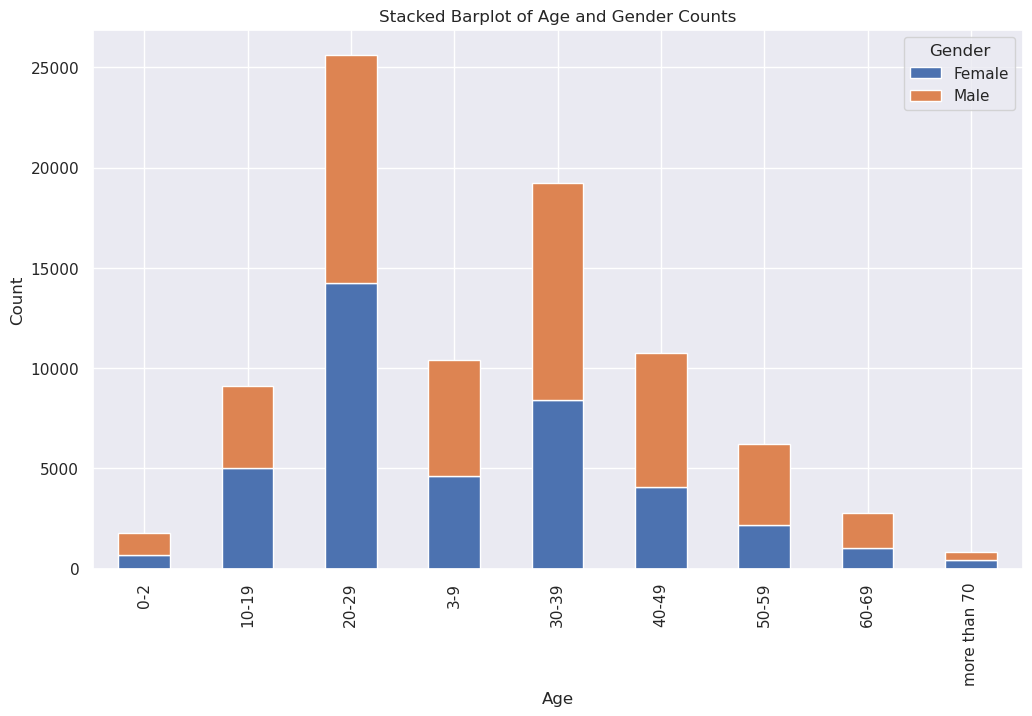

In [12]:
grouped_age_gender.plot(kind="bar", stacked=True, figsize=(12,7))
plt.title('Stacked Barplot of Age and Gender Counts')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Gender')

plt.show()

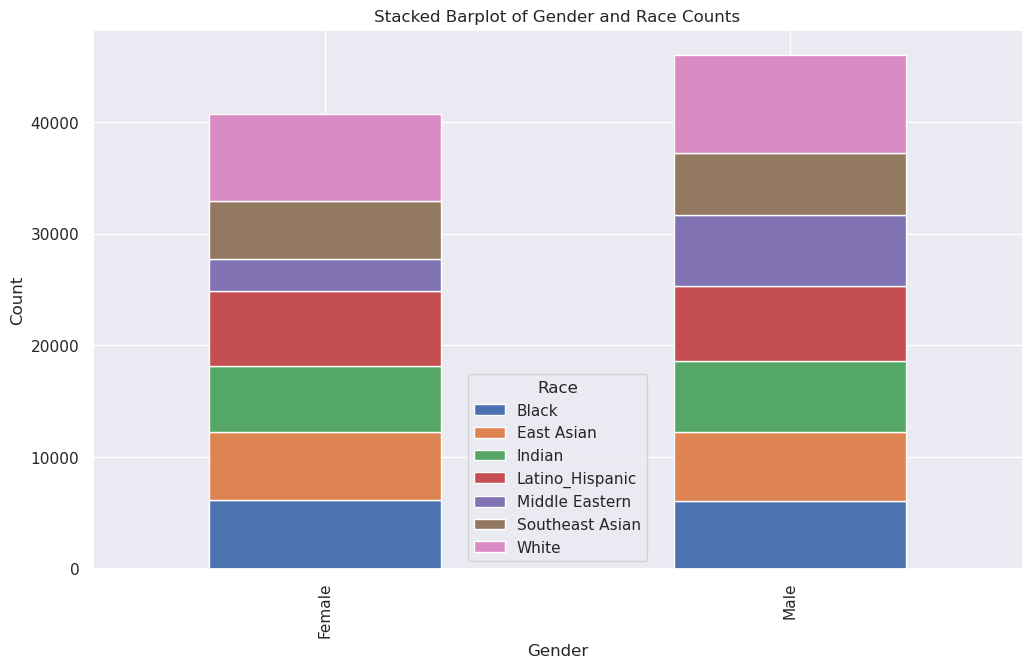

In [13]:
grouped_gender_race.plot(kind="bar", stacked=True, figsize=(12,7))
plt.title('Stacked Barplot of Gender and Race Counts')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Race')

plt.show()

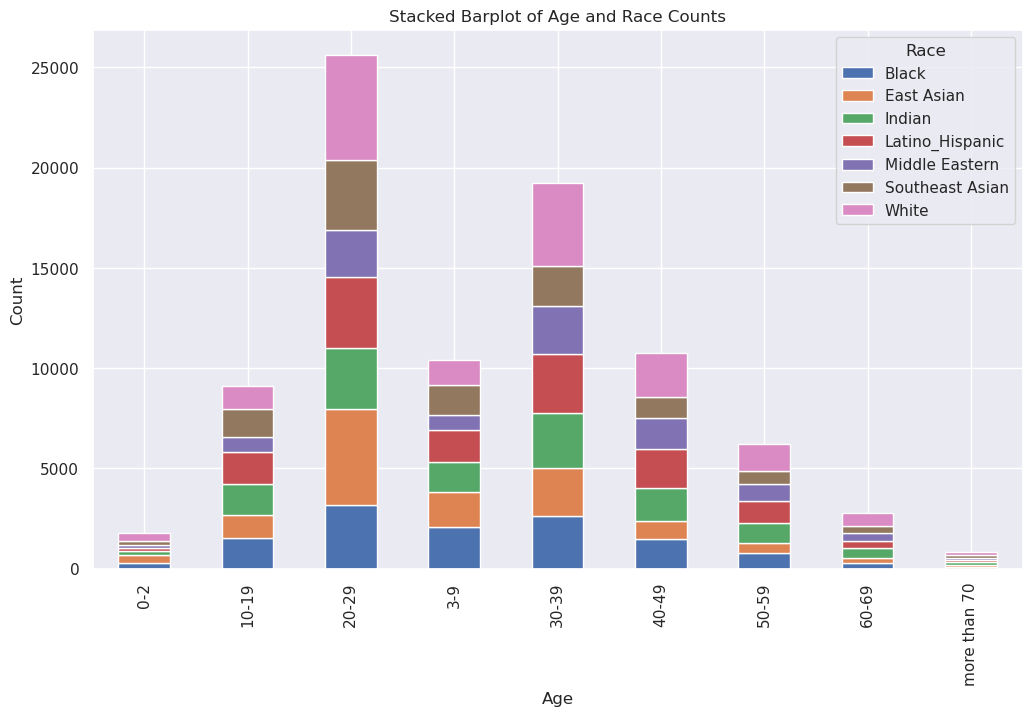

In [14]:
grouped_age_race.plot(kind="bar", stacked=True, figsize=(12,7))
plt.title('Stacked Barplot of Age and Race Counts')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Race')

plt.show()

### Some notes

There is some invalance between the different in the "age" column. As you can see in the plot 1 and 3, there are some categories that has less items, such as 0-2, 3-9, 10-19, 40-49, 50-59, and more than 70. It's possible that a little bias could be lead because of this issue.

## Dataframe preprocessing

I want to concatenate the dataset path to the "file" column. Also display an image example. and prerpocess the target columns to be onehotencoded inside themselves.

In [15]:
PATH_IMAGES = "../data/fairface"

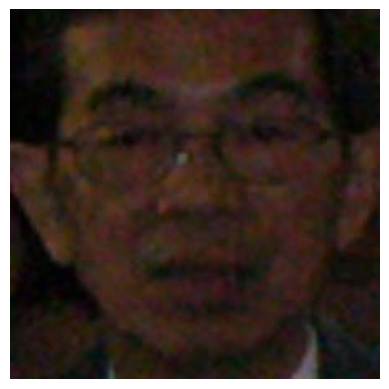

Dimentions: 224x224 (width x height)
Color mode: RGB


In [16]:
img = Image.open(f"{PATH_IMAGES}/train/1.jpg")
plt.imshow(img)
plt.axis('off')  
plt.show()

width, height = img.size
print(f"Dimentions: {width}x{height} (width x height)")

mode = img.mode
print(f"Color mode: {mode}")

As I mention, I encode the columns for the training set.

In [17]:
age_train = pd.get_dummies(metadata_train['age'], prefix="age")
gender_train = pd.get_dummies(metadata_train['gender'], prefix="gender")
race_train = pd.get_dummies(metadata_train['race'], prefix="race")
metadata_train = pd.concat([metadata_train, age_train, gender_train, race_train], axis=1)
print(metadata_train.columns)

Index(['file', 'age', 'gender', 'race', 'service_test', 'age_0-2', 'age_10-19',
       'age_20-29', 'age_3-9', 'age_30-39', 'age_40-49', 'age_50-59',
       'age_60-69', 'age_more than 70', 'gender_Female', 'gender_Male',
       'race_Black', 'race_East Asian', 'race_Indian', 'race_Latino_Hispanic',
       'race_Middle Eastern', 'race_Southeast Asian', 'race_White'],
      dtype='object')


And the validation set.

In [18]:
age_val = pd.get_dummies(metadata_train['age'], prefix="age")
gender_val = pd.get_dummies(metadata_train['gender'], prefix="gender")
race_val = pd.get_dummies(metadata_train['race'], prefix="race")
metadata_val = pd.concat([metadata_val, age_val, gender_val, race_val], axis=1)

In [19]:
age_columns = ['age_0-2', 'age_10-19', 'age_20-29', 'age_3-9', 'age_30-39', 'age_40-49', 'age_50-59',
       'age_60-69', 'age_more than 70']
gender_columns = ['gender_Female', 'gender_Male']
race_columns = ['race_Black', 'race_East Asian', 'race_Indian', 'race_Latino_Hispanic',
       'race_Middle Eastern', 'race_Southeast Asian', 'race_White']

Save a backup for performance measuring of the target column.

In [20]:
metadata_train["old_age"] = metadata_train["age"].copy()
metadata_train["old_gender"] = metadata_train["gender"].copy()
metadata_train["old_race"] = metadata_train["race"].copy()

metadata_val["old_age"] = metadata_val["age"].copy()
metadata_val["old_gender"] = metadata_val["gender"].copy()
metadata_val["old_race"] = metadata_val["race"].copy()

And then replace them with the one hot encoded equivalent.

In [21]:
metadata_train["age"] = list(metadata_train[age_columns].values)
metadata_train["gender"] = list(metadata_train[gender_columns].values)
metadata_train["race"] = list(metadata_train[race_columns].values)

metadata_val["age"] = list(metadata_val[age_columns].values)
metadata_val["gender"] = list(metadata_val[gender_columns].values)
metadata_val["race"] = list(metadata_val[race_columns].values)

In [22]:
target_columns = ["age", "gender", "race"]
metadata_train[target_columns].head()

,age,gender,race
0,"[False, False, False, False, False, False, Tru...","[False, True]","[False, True, False, False, False, False, False]"
1,"[False, False, False, False, True, False, Fals...","[True, False]","[False, False, True, False, False, False, False]"
2,"[False, False, False, True, False, False, Fals...","[True, False]","[True, False, False, False, False, False, False]"
3,"[False, False, True, False, False, False, Fals...","[True, False]","[False, False, True, False, False, False, False]"
4,"[False, False, True, False, False, False, Fals...","[True, False]","[False, False, True, False, False, False, False]"


Finally for this step, I add the rute to the file column.

In [23]:
# Add the rute to the file field
metadata_train['file'] = metadata_train['file'].apply(lambda x: PATH_IMAGES + "/" + x)
def is_valid_item(path):
    try:
        temp = "a/" + path
        return True
    except:
        return False
metadata_val = metadata_val[metadata_val["file"].apply(is_valid_item) == True]

metadata_val['file'] = metadata_val['file'].apply(lambda x: PATH_IMAGES + "/" + x)

## Model building

Here, I will build the used dataloaders and a deep CNN architecture for age/gender/race classification.

### Dataloaders building

In [24]:
# Dataset Definition
class MultiOutputDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # 
        img_path = self.df.iloc[idx]['file']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Obtener los targets
        age = torch.tensor(self.df.iloc[idx]['age'], dtype=torch.float32)
        gender = torch.tensor(self.df.iloc[idx]['gender'], dtype=torch.float32)
        race = torch.tensor(self.df.iloc[idx]['race'], dtype=torch.float32)
        
        return image, {'age': age, 'gender': gender, 'race': race}

# Normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [25]:
dataset_train = MultiOutputDataset(metadata_train, transform=transform)
dataset_val = MultiOutputDataset(metadata_val, transform=transform)

batch_size = 64
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

### Multioutput CNN Building

Here I will build a multioutput CNN with a dropout of 0.5 in the fully connected layers. The base architecture is the same for all the model, the only difference is the final layers that are independant for each target.

In [26]:
class MultiOutputCNN(nn.Module):
    def __init__(self):
        super(MultiOutputCNN, self).__init__()
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1_age = nn.Linear(256 * 14 * 14, 512)  # age (9 classes)
        self.fc2_age = nn.Linear(512, 9)
        
        self.fc1_gender = nn.Linear(256 * 14 * 14, 512)  # gender (2 classes)
        self.fc2_gender = nn.Linear(512, 2)
        
        self.fc1_race = nn.Linear(256 * 14 * 14, 512)  # race (7 classes)
        self.fc2_race = nn.Linear(512, 7)
    
    def forward(self, x):
        # Parte convolucional compartida
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, 256 * 14 * 14)  # Flatten
        
        age = F.relu(self.fc1_age(x))
        age = self.dropout(age) 
        age = self.fc2_age(age)
        
        gender = F.relu(self.fc1_gender(x))
        gender = self.dropout(gender)
        gender = self.fc2_gender(gender)
        
        race = F.relu(self.fc1_race(x))
        race = self.dropout(race)
        race = self.fc2_race(race)
        
        return {'age': age, 'gender': gender, 'race': race}

Finally set the loss criterion and the optimizer function.

In [27]:
# Creating the model
model = MultiOutputCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss functions
criterion_age = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()
criterion_race = nn.CrossEntropyLoss()

## Model training

Here I will train the model. I set a custom Early stopping to avoid overfiting. In general, the base architecture must converge in few epochs, but in any case I set a patiente to be 3. I validate the model in every epoch to see its performance step by step.

In [28]:
# Define the loss history
train_loss_history = []
val_loss_history = []
min_val_loss = 999999999
no_change = 0
# Entrenamiento con validación
num_epochs = 30

In [29]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    # Training
    train_loader = tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    
    for images, targets in train_loader:
        optimizer.zero_grad()

        # Moving the set to device
        images = images.to(device)
        targets['age'] = targets['age'].to(device)
        targets['gender'] = targets['gender'].to(device)
        targets['race'] = targets['race'].to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Loss measurement
        loss_age = criterion_age(outputs['age'], targets['age'].argmax(dim=1))
        loss_gender = criterion_gender(outputs['gender'], targets['gender'].argmax(dim=1))
        loss_race = criterion_race(outputs['race'], targets['race'].argmax(dim=1))
        
        # Total Loss
        loss = loss_age + loss_gender + loss_race
        loss.backward()  # Backpropagation
        optimizer.step()  # Weights update
        
        running_train_loss += loss.item()

        train_loader.set_postfix({'Train Loss': loss.item()}) 
    
    # Saving the average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    # Validation
    model.eval()  # Set the evaluation mode
    running_val_loss = 0.0

    val_loader = tqdm(dataloader_val, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
    
    with torch.no_grad():  # Not calculating the gradients
        for images, targets in val_loader:
            # Moving the set to device
            images = images.to(device)
            targets['age'] = targets['age'].to(device)
            targets['gender'] = targets['gender'].to(device)
            targets['race'] = targets['race'].to(device)
                
            # Forward pass
            outputs = model(images)
            
            # Loss measurement
            loss_age = criterion_age(outputs['age'], targets['age'].argmax(dim=1))
            loss_gender = criterion_gender(outputs['gender'], targets['gender'].argmax(dim=1))
            loss_race = criterion_race(outputs['race'], targets['race'].argmax(dim=1))
            
            # Total Loss
            loss = loss_age + loss_gender + loss_race
            running_val_loss += loss.item()
            
            val_loader.set_postfix({'Val Loss': loss.item()})
    
    
    # Saving the average validation loss
    avg_val_loss = running_val_loss / len(dataloader_val)
    val_loss_history.append(avg_val_loss)

    if min_val_loss > avg_val_loss:
        min_val_loss = avg_val_loss + 0
        no_change = 0
    else:
        no_change += 1
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')
    if no_change == 3:
        print("Early stopping reached because of no reduction in val loss")
        break

Epoch 1/30 - Validation: 100%|████████████████████████████████████████████████████████████████████████| 172/172 [00:10<00:00, 15.89it/s, Val Loss=5.35]


Epoch [1/30], Train Loss: 3.661281756067698, Val Loss: 7.0187865301620125


Epoch 2/30 - Validation: 100%|████████████████████████████████████████████████████████████████████████| 172/172 [00:11<00:00, 14.41it/s, Val Loss=7.02]


Epoch [2/30], Train Loss: 3.013475640860982, Val Loss: 8.119631007660267


Epoch 3/30 - Validation: 100%|████████████████████████████████████████████████████████████████████████| 172/172 [00:11<00:00, 15.00it/s, Val Loss=7.55]


Epoch [3/30], Train Loss: 2.7846808533752916, Val Loss: 9.294315196747004


Epoch 4/30 - Validation: 100%|████████████████████████████████████████████████████████████████████████| 172/172 [00:12<00:00, 13.82it/s, Val Loss=8.17]

Epoch [4/30], Train Loss: 2.6196938376862744, Val Loss: 9.512291151423787
Early stopping reached because of no reduction in val loss


A something interesting here. It seems that the model overfits from the early begining. If you notice, the validation loss only increase from the first epoch. This will be avoided in future works, mainly the first measures to take is reduce the architecture complexity and use dropout.

## Model evaluation

To evaluate the model, I will parse the predicted values to their true string format values and measure the performance with the accuracy evalueation metric and heatmaps in each target column to see against which categories the target gets confused.

In [30]:
def predict_dataloader(model, dataloader, device):
    model.eval()  # Poner el modelo en modo evaluación
    pred_ages = []
    pred_genders = []
    pred_races = []
    
    with torch.no_grad():  # No necesitamos calcular gradientes
        for images, _ in dataloader:
            images = images.to(device)  # Mover las imágenes al dispositivo

            # Obtener las predicciones
            outputs = model(images)
            
            # Extraer los índices de predicción
            pred_age = torch.argmax(outputs['age'], dim=1).cpu().numpy()     # Predicciones de edad
            pred_gender = torch.argmax(outputs['gender'], dim=1).cpu().numpy()  # Predicciones de género
            pred_race = torch.argmax(outputs['race'], dim=1).cpu().numpy()   # Predicciones de raza

            # Almacenar las predicciones en las listas
            pred_ages.extend(pred_age)
            pred_genders.extend(pred_gender)
            pred_races.extend(pred_race)
    
    return pred_ages, pred_genders, pred_races

In [31]:
pred_ages, pred_genders, pred_races = predict_dataloader(model, dataloader_val, device)

In [32]:
metadata_val["pred_ages"] = [age_columns[elem] for elem in pred_ages]
metadata_val["pred_genders"] = [gender_columns[elem] for elem in pred_genders]
metadata_val["pred_races"] = [race_columns[elem] for elem in pred_races]

In [33]:
metadata_val["pred_ages"] = metadata_val["pred_ages"].apply(lambda x: x[4:])
metadata_val["pred_genders"] = metadata_val["pred_genders"].apply(lambda x: x[7:])
metadata_val["pred_races"] = metadata_val["pred_races"].apply(lambda x: x[5:])

### Predicted Age vs Actual Age category heatmap

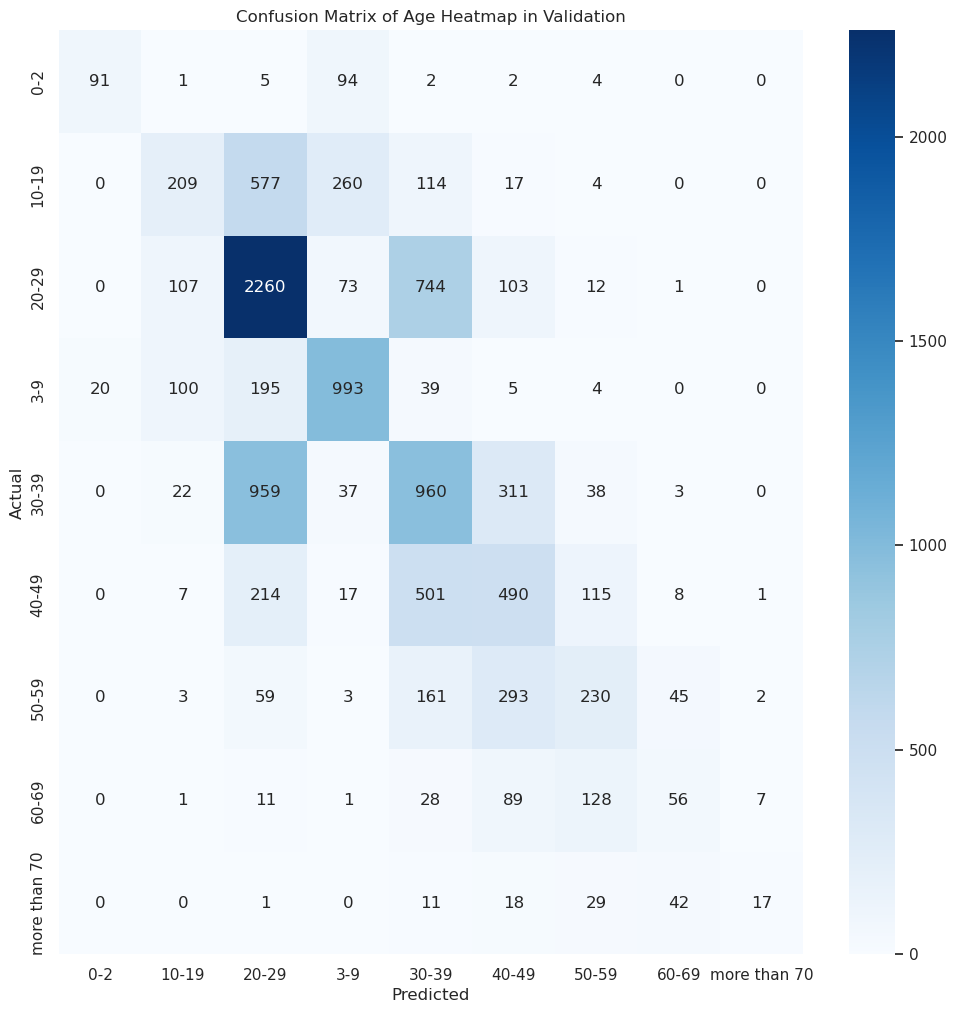

In [34]:
labels = sorted(list(set(metadata_val['old_age']).union(set(metadata_val['pred_ages']))))

conf_mat = confusion_matrix(metadata_val['old_age'], metadata_val['pred_ages'], labels=labels)

plt.figure(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Age Heatmap in Validation')

plt.show()

Interesting, The model gets confused against their neightbors categories. You can notice that the 10-19 values is misclassified with the 20-29 category. Also the 20-29 and the 30-39 categories are misclassified mutually. Also the 30-39 confuses with the 40-49 and the 40-49 with the 50-59 are mutually misclassified.

### Predicted Genders vs Actual Genders category heatmap

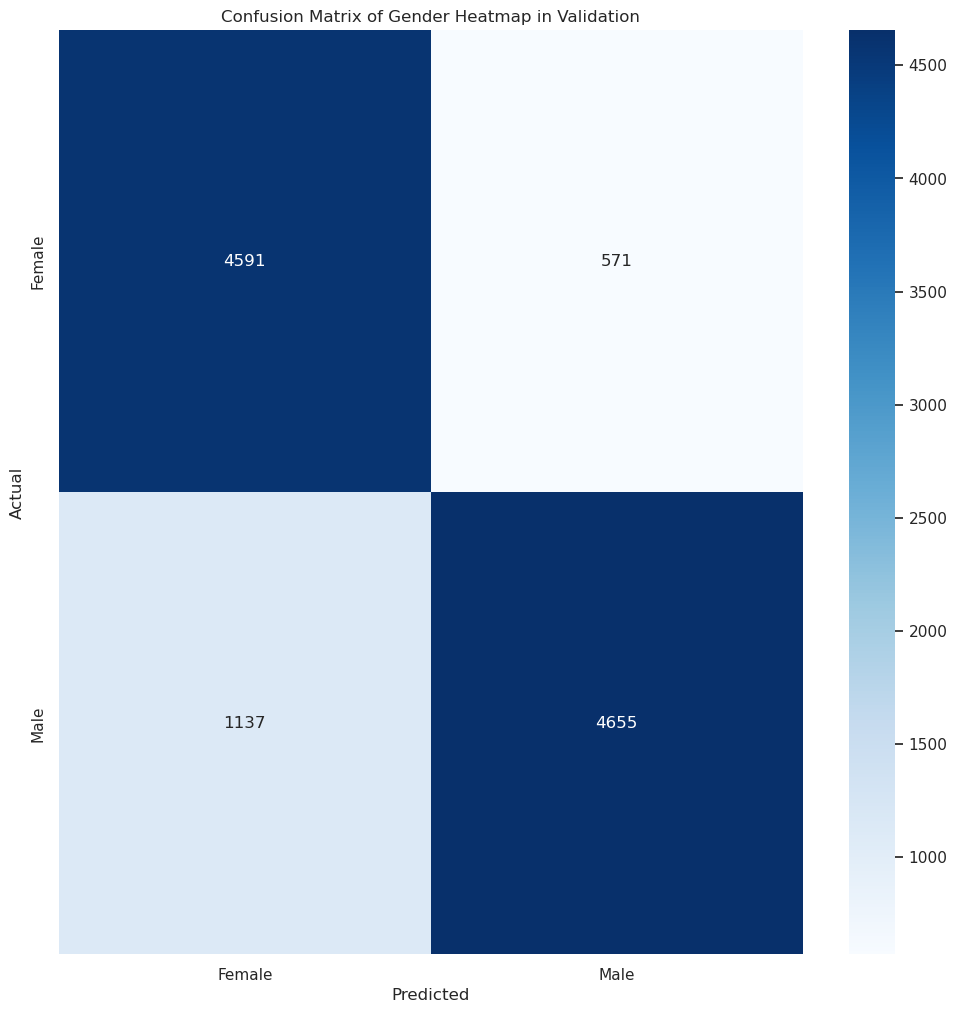

In [35]:
labels = sorted(list(set(metadata_val['old_gender']).union(set(metadata_val['pred_genders']))))

conf_mat = confusion_matrix(metadata_val['old_gender'], metadata_val['pred_genders'], labels=labels)

plt.figure(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Gender Heatmap in Validation')

plt.show()

Here most of the predictions are correctly classified. There is a small bias in this classification though.

### Predicted Races vs Actual Races category heatmap

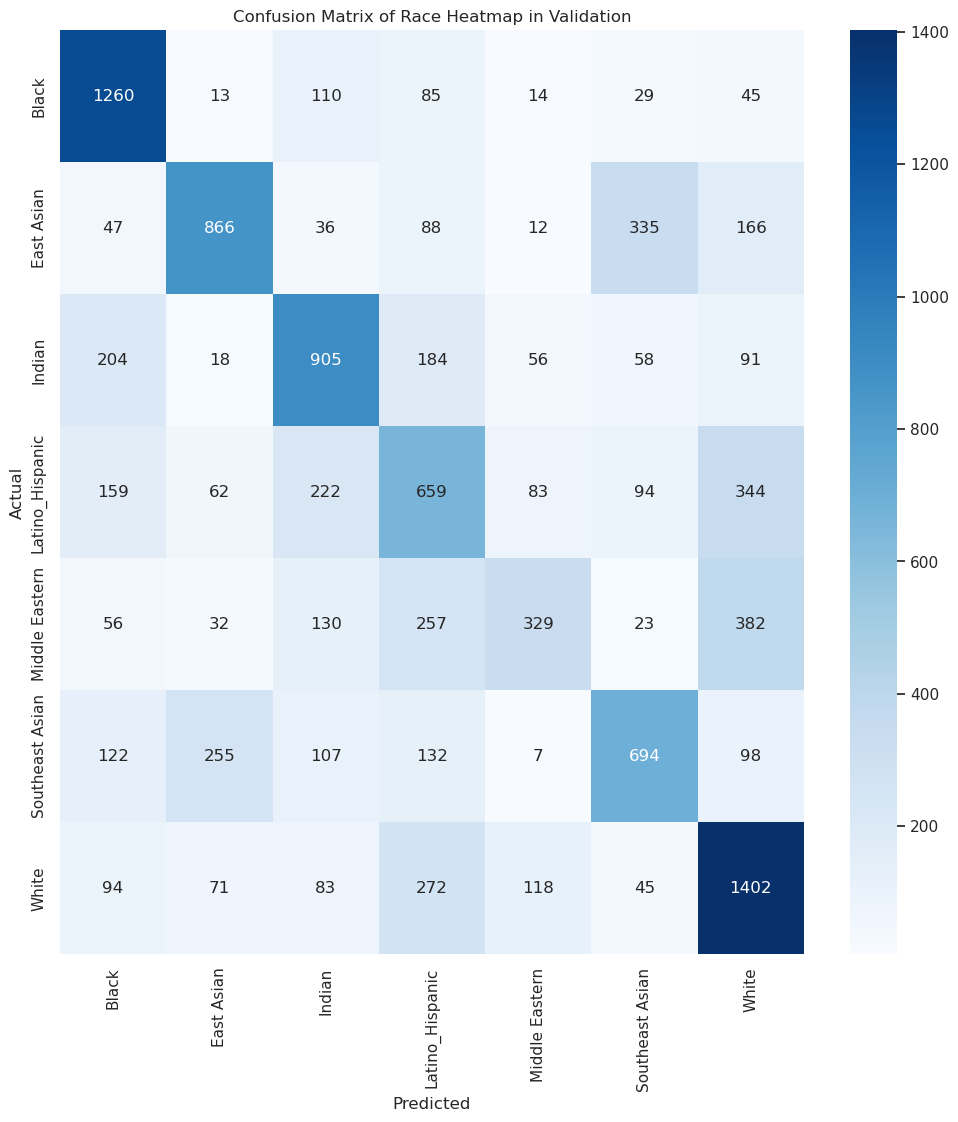

In [36]:
labels = sorted(list(set(metadata_val['old_race']).union(set(metadata_val['pred_races']))))

conf_mat = confusion_matrix(metadata_val['old_race'], metadata_val['pred_races'], labels=labels)

plt.figure(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Race Heatmap in Validation')

plt.show()

Here, With this heatmap I answer the project query, which is the correct classification of Black race against the White one. Here the bias against the Black race was much less than the White one, where mostly of its bias is misclassified as Latino_Hispanic and Middle Eastern.

### Model's accuracies in the different targets

In [37]:
print("Final Validation Accuracy in Age:", (metadata_val['old_age'] == metadata_val['pred_ages']).mean()*100)
print("Final Validation Accuracy in Gender:", (metadata_val['old_gender'] == metadata_val['pred_genders']).mean()*100)
print("Final Validation Accuracy in Race:", (metadata_val['old_race'] == metadata_val['pred_races']).mean()*100)

Final Validation Accuracy in Age: 48.43892641957276
Final Validation Accuracy in Gender: 84.4075223662589
Final Validation Accuracy in Race: 55.82435639948877


Interestingly enough, the best performance target column is gender. Here is a important note, The random classification threshold in Age is 100 over the number of age categories (9), in other words 11.11%. in the case of Gender is 50%, and in the case of Race is 14.29%. 

In other words, as more categories in the target column, the problem complexity is higher. That's why the Age and Race performance is medium.

On the other hand, some of the biases could be explained for ethnical characteristics that belongs to each race and some shared between them. Also is the same in the case of Age groups. But, in the end, the model presented a valid approach to solve this problem.

## Conclusions

In this work, I trained a CNN to address the Age/Gender/Race classification of people. The results shows an overall improvement of random thresholds and a valid approach comparing to determined races such as Black which was the one with the lowest bias. In future works, I want to improve the CNN architecture, test with pictures of people from my country and other related experiments.